# StarFused Package Usage Examples

This notebook demonstrates how to use the `starfused` package for:
- Querying photometric data from VizieR
- Applying dust extinction corrections
- Loading stellar atmosphere models

In [1]:
from starfused import Photometry, StellarModel
import matplotlib.pyplot as plt
import numpy as np

## Example 1: Query Photometric Data

Query photometric data for a source by name or coordinates.

In [2]:
# Query by source name
phot_data = Photometry.query(
    name="Gaia DR3 573956069112683392",
    filters=['GALEX', 'UVOT', 'SDSS', 'Gaia', '2MASS', 'WISE'],
    radius=1
)

print(f"Retrieved {len(phot_data)} photometric measurements")
phot_data[['sed_filter', 'sed_wave', 'sed_flux', 'sed_eflux']]

Retrieved 17 photometric measurements


,sed_filter,sed_wave,sed_flux,sed_eflux
0,UVOT:UVW2,1928.0,1.217759e-16,1.100607e-17
1,UVOT:UVM2,2246.0,5.806391e-17,1.276757e-17
2,GALEX:NUV,2312.0,6.730380e-17,1.346076e-17
3,UVOT:UVW1,2600.0,2.656224e-16,1.204392e-17
4,UVOT:U,3465.0,9.538403e-16,1.939505e-17
5,UVOT:B,4392.0,1.818381e-15,4.279855e-17
6,SDSS:g,4820.0,1.845305e-15,2.737400e-17
7,UVOT:V,5468.0,1.744687e-15,1.192856e-15
8,SDSS:r,6247.0,1.613244e-15,1.086423e-17
9,Gaia:G,6730.0,1.204670e-15,2.547323e-16


## Example 2: Apply Dust Extinction Correction

Correct photometry for interstellar dust extinction.

In [3]:
# Apply Milky Way dust correction
corrected_data = Photometry.dust_correction(
    phot_data,
    extinction='mw',
    dustmap='SandF'
)

corrected_data[['sed_filter', 'sed_wave', 'sed_flux', 'sed_eflux']]

Retrived E(B-V) = 0.074 from SandF dust map.


,sed_filter,sed_wave,sed_flux,sed_eflux
0,UVOT:UVW2,1928.0,2.134405e-16,1.929071e-17
1,UVOT:UVM2,2246.0,1.100126e-16,2.419046e-17
2,GALEX:NUV,2312.0,1.218679e-16,2.437357e-17
3,UVOT:UVW1,2600.0,4.180949e-16,1.895737e-17
4,UVOT:U,3465.0,1.336111e-15,2.716801e-17
5,UVOT:B,4392.0,2.404332e-15,5.658986e-17
6,SDSS:g,4820.0,2.364098e-15,3.506999e-17
7,UVOT:V,5468.0,2.156447e-15,1.474379e-15
8,SDSS:r,6247.0,1.936111e-15,1.303855e-17
9,Gaia:G,6730.0,1.423122e-15,3.009248e-16


### Compare Original vs Dust-Corrected Photometry

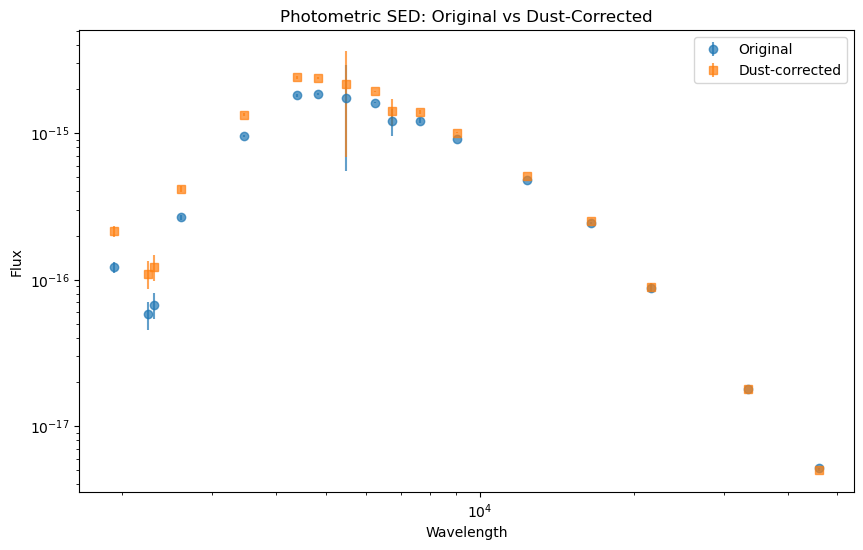

In [4]:
plt.figure(figsize=(10, 6))
plt.errorbar(phot_data['sed_wave'], phot_data['sed_flux'], 
             yerr=phot_data['sed_eflux'], fmt='o', label='Original', alpha=0.7)
plt.errorbar(corrected_data['sed_wave'], corrected_data['sed_flux'], 
             yerr=corrected_data['sed_eflux'], fmt='s', label='Dust-corrected', alpha=0.7)
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Photometric SED: Original vs Dust-Corrected')
plt.show()

## Example 3: Load Stellar Atmosphere Model

Load a stellar atmosphere model spectrum from the CK04 grid.

In [5]:
# Initialize stellar model
model = StellarModel(grid='ck04')

# Load a solar-type star model
spectrum = model.load_model(
    teff=5750,      # Effective temperature (K)
    logg=4.5,       # Surface gravity
    metallicity=0.0 # Solar metallicity
)

print(f"Loaded spectrum with {len(spectrum)} wavelength points")
spectrum.head()

Loading model: Teff=5750K, log_g=4.5, [M/H]=0.0
Loaded spectrum with 1221 wavelength points


,wavelength,flux
0,90.900002,0.0
1,93.500000,0.0
2,96.099998,0.0
3,97.699997,0.0
4,99.599998,0.0


### Plot the Stellar Model Spectrum

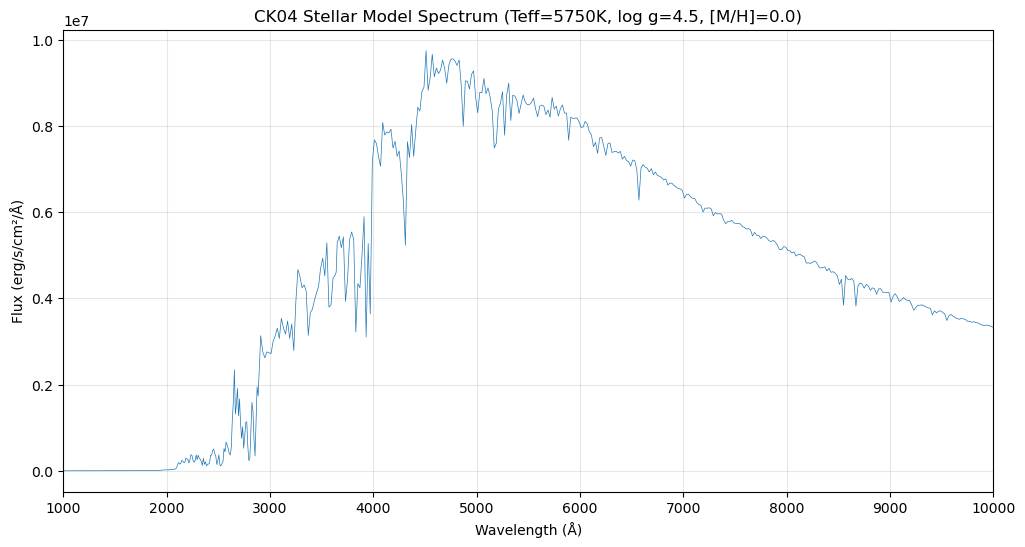

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(spectrum['wavelength'], spectrum['flux'], linewidth=0.5)
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux (erg/s/cm²/Å)')
plt.title('CK04 Stellar Model Spectrum (Teff=5750K, log g=4.5, [M/H]=0.0)')
plt.xlim(1000, 10000)
plt.grid(True, alpha=0.3)
plt.show()

## Example 4: Find Closest Available Model

Find the closest available model parameters in the grid.

In [7]:
# Query what model would be used for given parameters
params = model.find_model(
    teff=5800,
    logg=4.3,
    metallicity=0.1
)

print("Requested parameters:")
print("  Teff: 5800 K")
print("  log g: 4.3")
print("  [M/H]: 0.1")
print("\nClosest available model:")
for key, value in params.items():
    print(f"  {key}: {value}")

Requested parameters:
  Teff: 5800 K
  log g: 4.3
  [M/H]: 0.1

Closest available model:
  teff: 5750
  logg: 4.3
  metallicity: 0.0
  dirname: ckp00
  filename: ckp00_5750.fits


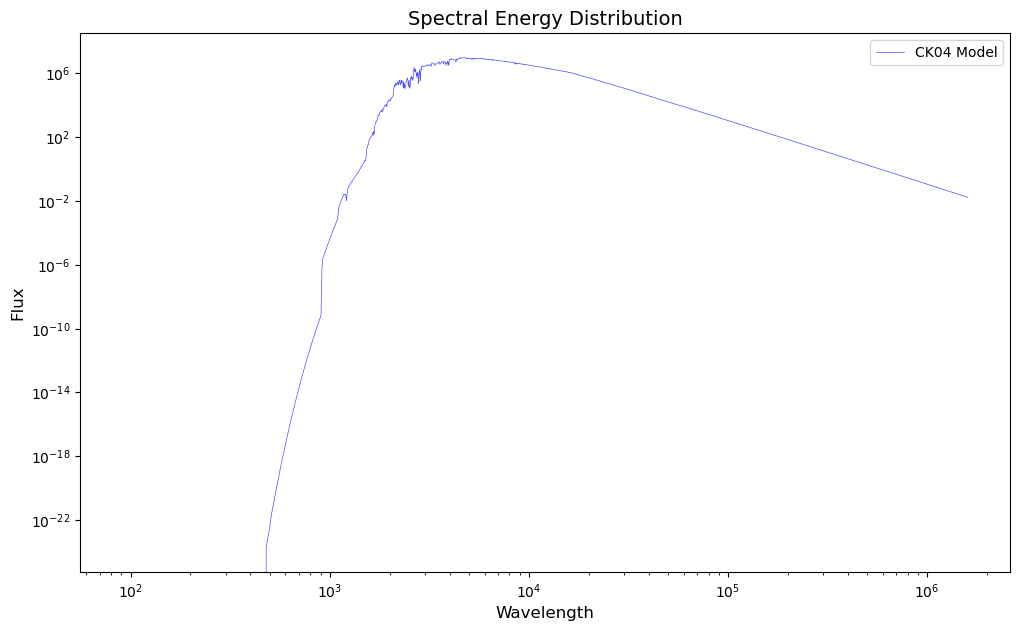

In [8]:
plt.figure(figsize=(12, 7))

plt.plot(spectrum['wavelength'], spectrum['flux'], 
         linewidth=0.5, color='blue', alpha=0.7, label='CK04 Model')
plt.xlabel('Wavelength', fontsize=12)
plt.ylabel('Flux', fontsize=12)
plt.title('Spectral Energy Distribution', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=10)
plt.show()